In [1]:
import os
import sys
import numpy                                  as np
import time
import shutil
import seaborn                                as sns
import pandas                                 as pd

In [2]:
WORKSPACE_PATH   = os.getenv('WORKSPACE_PATH')  

PathToOutputFldr =  WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/'

### O2+O
Molecules        = ['O2_UMN']
PathToDiatPot    = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp']

# ### N2+N
# Molecules        = ['N2_LeRoy']
# PathToDiatPot    = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp']

# ### N2+O
# Molecules        = ['N2_UMN_ForN2O2', 'NO_UMN']
# PathToDiatPot    = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/UMN_ForN2O2/Recomputed.inp', 
#                     WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/NO/UMN/Recomputed.inp']

In [3]:
def compute_vibenergy(eint, vqn, jqn):
    NLevels = len(eint)
    EVib    = np.zeros((NLevels,1))
    ERot    = np.zeros((NLevels,1))
    ETemp   = np.zeros((np.amax(vqn)+1,1))
    for iLevel in range(NLevels):
        if (jqn[iLevel] == 0):
            EVib[iLevel]       = eint[iLevel]
            ETemp[vqn[iLevel]] = eint[iLevel]
        else:
            EVib[iLevel] = ETemp[vqn[iLevel]]
            ERot[iLevel] = eint[iLevel] - EVib[iLevel]
    return EVib, ERot

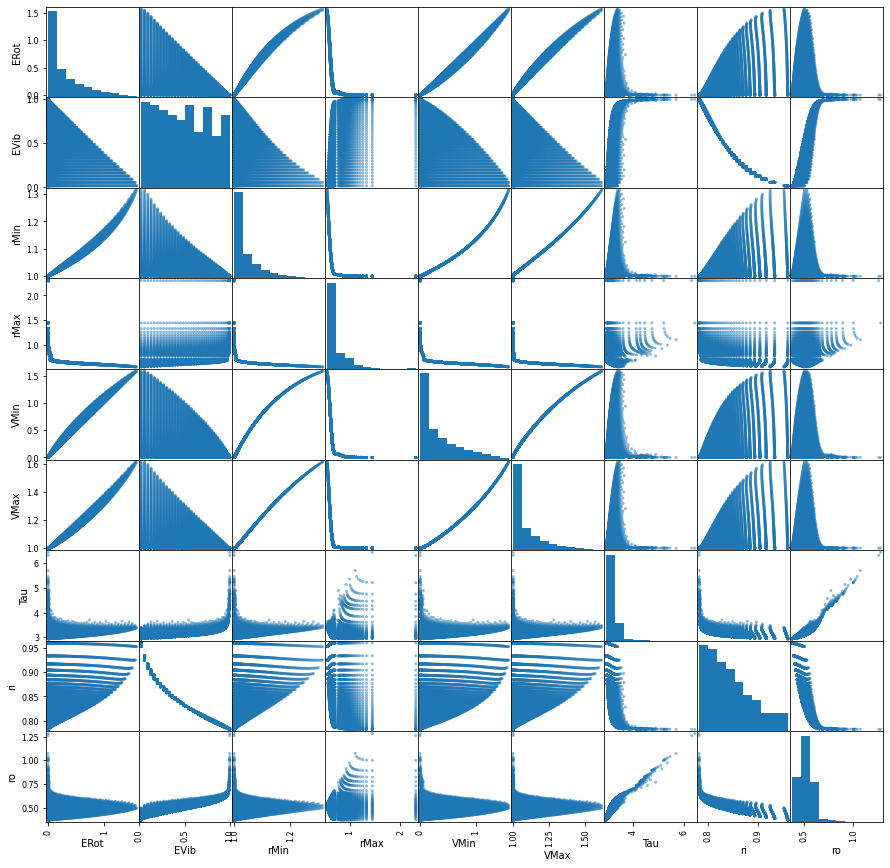

In [4]:
NMolecules = len(Molecules)
for iMol in range(NMolecules):
    
    ### Reading Levels Data
    LevelsData            = pd.read_csv(PathToDiatPot[iMol], delim_whitespace=True, skiprows=15, header=None)
    LevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    
    
    
    ### Shifting Energies so that Zero is the Min of Diatomic Potential at J=0
    LevelsData['EInt']    = LevelsData['EInt'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())
    LevelsData['VMax']    = LevelsData['VMax'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())
    LevelsData['VMin']    = LevelsData['VMin'].to_numpy() -  np.amin(LevelsData['VMin'].to_numpy())
    
    
    ### Splitting Energy in Rotational and Vibrational Contribution
    EVib, ERot            = compute_vibenergy(LevelsData.EInt.to_numpy(), LevelsData.vqn.to_numpy(int), LevelsData.jqn.to_numpy(int))
    LevelsData['EVib']    = EVib
    LevelsData['ERot']    = ERot
    
    LevelsDataNew         = LevelsData.copy()
    LevelsDataNew.head()
    
    
    ### Normalizing Variables 
    VDiss                 = LevelsData['VMax'].to_numpy()[0]
    LevelsDataNew['EVib'] = LevelsData.EVib.to_numpy() / VDiss
    LevelsDataNew['ERot'] = LevelsData.ERot.to_numpy() / VDiss
    LevelsDataNew['VMax'] = LevelsData.VMax.to_numpy() / VDiss
    LevelsDataNew['VMin'] = LevelsData.VMin.to_numpy() / VDiss
    
    rMin                  = np.amin(LevelsData['rMin'].to_numpy())
    LevelsDataNew['ri']   = LevelsData.ri.to_numpy()   / LevelsData.rMin.to_numpy()
    LevelsDataNew['ro']   = LevelsData.ro.to_numpy()   / LevelsData.rMin.to_numpy()
    LevelsDataNew['rMin'] = LevelsData.rMin.to_numpy() / rMin
    LevelsDataNew['rMax'] = LevelsData.rMax.to_numpy() / rMin
    
    TauMin                = np.amax(LevelsData['Tau'].to_numpy())
    LevelsDataNew['Tau']  = LevelsData.Tau.to_numpy()  / TauMin
    
    
    ### Taking Logarithms
    #LevelsDataNew['EVib'] = np.exp(LevelsData.EVib.to_numpy())
    #LevelsDataNew['ERot']  = np.exp(LevelsData.ERot.to_numpy() + 1.e-6)
    LevelsDataNew['Tau']   = np.log10(LevelsData.Tau.to_numpy())
    LevelsDataNew['ro']    = np.log10(LevelsData.ro.to_numpy())
    LevelsDataNew['rMax']  = np.log10(LevelsData.rMax.to_numpy())
    #LevelsDataNew['ri']    = np.log10(LevelsData.ri.to_numpy())
    #LevelsDataNew['rMin']  = np.log10(LevelsData.rMin.to_numpy())
    
    pd.plotting.scatter_matrix(LevelsDataNew[['ERot','EVib','rMin','rMax','VMin','VMax','Tau','ri','ro']], figsize=(15,15))

    
    
    ### Writing Data File
    LevelsDataNew.to_csv(PathToOutputFldr+Molecules[iMol]+'_nd.csv', index=False)

array([[<AxesSubplot:title={'center':'Temp'}>]], dtype=object)

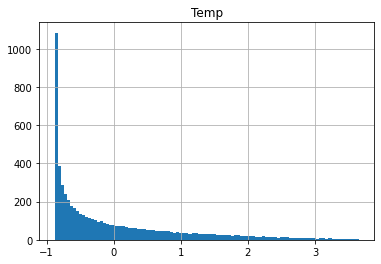

In [5]:
### ERot

Mean = LevelsData.ERot.mean()
Std  = LevelsData.ERot.std()

#LevelsDataNew['Temp']  = LevelsData.ERot.to_numpy()
LevelsDataNew['Temp']  = (LevelsData.ERot.to_numpy() - Mean)/Std
LevelsDataNew.hist(bins=100, column=['Temp'])

array([[<AxesSubplot:title={'center':'Temp'}>]], dtype=object)

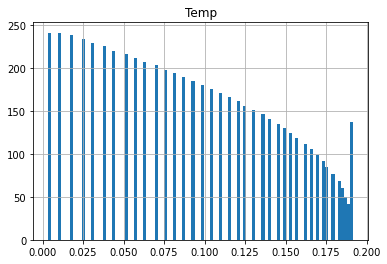

In [6]:
### EVib

Mean = LevelsData.EVib.mean()
Std  = LevelsData.EVib.std()

LevelsDataNew['Temp']  = LevelsData.EVib.to_numpy()
#LevelsDataNew['Temp']  = (LevelsData.EVib.to_numpy() - Mean)/Std
LevelsDataNew.hist(bins=100, column=['Temp'])

array([[<AxesSubplot:title={'center':'Temp'}>]], dtype=object)

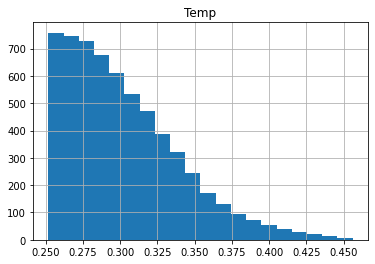

In [7]:
### rIn

LevelsDataNew['Temp']  = np.log10(LevelsData.ri.to_numpy())#**(-6)
LevelsDataNew.hist(bins=20, column=['Temp'])

array([[<AxesSubplot:title={'center':'Temp'}>]], dtype=object)

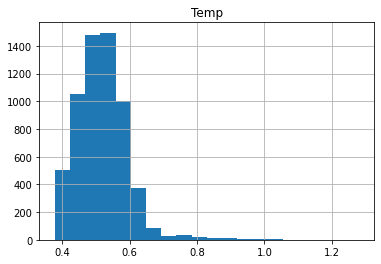

In [8]:
### rOut

LevelsDataNew['Temp']  = np.log10(LevelsData.ro.to_numpy())#**(-6)
LevelsDataNew.hist(bins=20, column=['Temp'])

array([[<AxesSubplot:title={'center':'Temp'}>]], dtype=object)

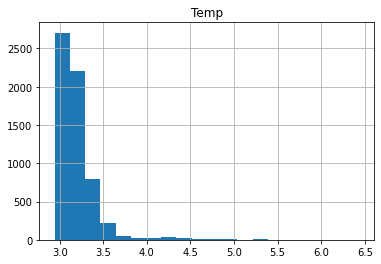

In [9]:
### Tau

LevelsDataNew['Temp']  = np.log10(LevelsData.Tau.to_numpy())#**(-6)
LevelsDataNew.hist(bins=20, column=['Temp'])

In [15]:
from datetime import datetime

def get_curr_time():
    return datetime.now().strftime("%Y.%m.%d.%H.%M.%S")

def get_start_time():
    return get_curr_time()

_start_time = get_start_time()

print(_start_time)

2021.07.26.21.02.09
